# Test: a massa dei neutrini fissa faccio la regressione su $k$ e $z$

In [125]:
import os
import numpy as np
from pysr import *
from matplotlib import pyplot as plt
from importlib import reload
from classy import Class
import functions as f
import pandas as pd

In [126]:
nk = 50
nz = 10
filepath = 'files'

# valori fissi di massa del neutrino
mm = np.array([0.06, 1])
nm = len(mm)


#zz = np.load('files/redshift.npy')
#kk = np.load('files/scale.npy')
zz = np.linspace(0, 10, nz)
kk = np.logspace(-4, np.log10(3), nk)       # k è in h/Mpc

# Primo metodo

In [127]:
# la prima volta che si esegue questo notebook bisoagna far partire questa cella, così si è sicuri che i file vengano generati da class correttamente

cosmos = []
mu =  []
for i in range(nm) :
    cosmos.append(f.DataFromCLASS(nk, nz, mm[i], filepath))
    mu.append(cosmos[i]['growth_ratio'])
mu = np.array(mu)
print(mu.shape)


(2, 50, 10)


In [128]:
# se non è la prima volta che esegui questo notebook esegui questa cella, che carica i file già generati
'''
mu = []
for m in mm :
    mupath = 'files/Mu(k,z)_m-neu=' + str(round(m, 3)) + '.npy'
    mu.append(np.load(mupath))
mu = np.array(mu)
print(mu.shape)
'''

"\nmu = []\nfor m in mm :\n    mupath = 'files/Mu(k,z)_m-neu=' + str(round(m, 3)) + '.npy'\n    mu.append(np.load(mupath))\nmu = np.array(mu)\nprint(mu.shape)\n"

In [129]:
model_fix1 = PySRRegressor(
    binary_operators = ["+", "-", "*", "/", "^"],
    unary_operators=["exp", "log"],
    niterations=40,
    loss = "L2DistLoss()",
    model_selection = "best",
    equation_file = "models/model_fix1.csv"
    )

In [130]:
# creazione dei dati su cui allenare il modello

# controllino
if (len(mu[:,0,0]) != nm) :
    print('Error! dim(Mu[:,0,0]) ≠ dim(mass)')
elif (len(mu[0,:,0]) != nk) :
    print('Error! dim(Mu[0,:,0]) ≠ dim(scale)')
elif (len(mu[0,0,:]) != nz) :
    print('Error! dim(Mu[0,:,0]) ≠ dim(redshift)')

data = np.zeros([nm*nk*nz, 4])
for m in range(nm) :
    for k in range(nk) :
        for z in range(nz) :
            data[m+k+z,0] = mm[m]
            data[m+k+z,1] = kk[k]
            data[m+k+z,2] = zz[z]
            data[m+k+z,3] = mu[m,k,z]

            # print(data[m+k+z,0], '\t', data[m+k+z,1], '\t', data[m+k+z,2], '\t', data[m+k+z,3])

# l'array 'data' è così strutturato:
# masse neutrino | k (scala) | redshift | valore di mu

In [131]:
x = []
x.append(data[:nk*nz, :])
x.append(data[nk*nz:, :])

In [132]:
# alleno il modello per due valori distinti di massa del neutrino
pred1 = []

# m = 0.06 eV
model_fix1.fit(x[0][:,:2], x[0][:,3])
pred1.append(model_fix1.predict(x[0][:,:2]))

# m = 1 eV
model_fix1.fit(x[1][:,:2], x[1][:,3])
pred1.append(model_fix1.predict(x[1][:,:2]))

/opt/homebrew/lib/python3.11/site-packages/pysr/sr.py:1261: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/pysr/sr.py:60: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://astroautomata.com/PySR/tuning/
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/pysr/sr.py:1793: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/pysr/sr.py:1261: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  

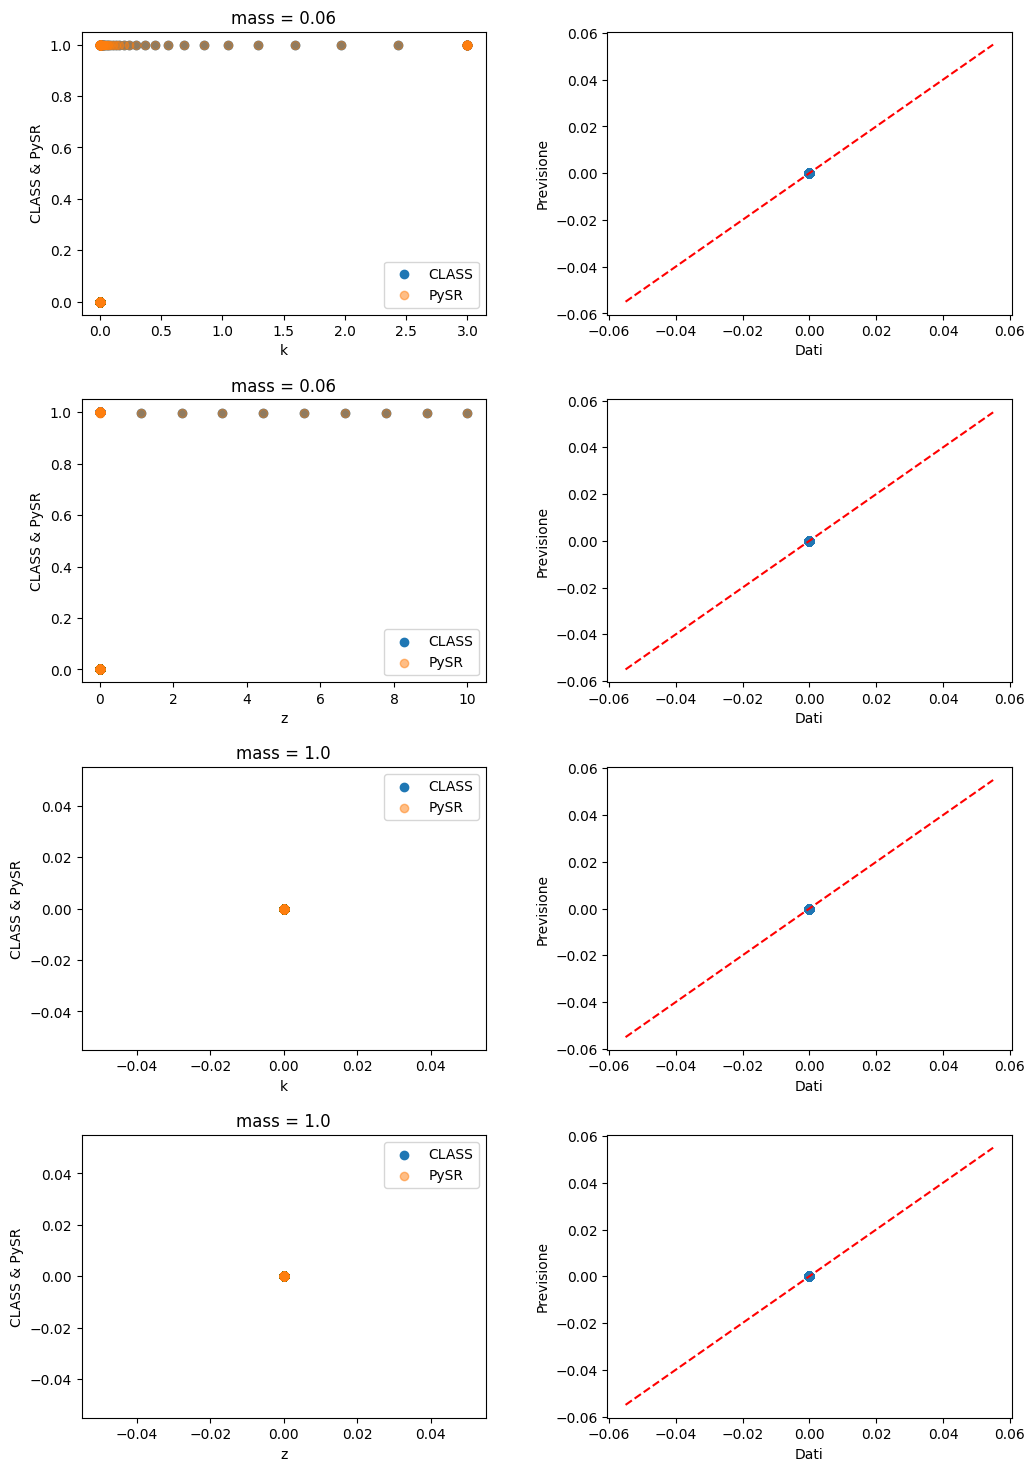

In [133]:
# plotto le predizioni di PySR contro i dati di CLASS

fig, axs = plt.subplots(4, 2, figsize=(12, 18), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

j = 0
for m in range(nm) :
    # x: scala
    axs[j,0].scatter(x[m][:,1], x[m][:,3], label='CLASS')
    axs[j,0].scatter(x[m][:,1], pred1[m][:], alpha=0.5, label='PySR')
    axs[j,0].set_xlabel('k')
    axs[j,0].set_ylabel('CLASS & PySR')
    axs[j,0].set_title('mass = ' + str(mm[m]))
    axs[j,0].legend()

    j = j+1

    # x: redshift
    axs[j,0].scatter(x[m][:,2], x[m][:,3], label='CLASS')
    axs[j,0].scatter(x[m][:,2], pred1[m][:], alpha=0.5, label='PySR')
    axs[j,0].set_xlabel('z')
    axs[j,0].set_ylabel('CLASS & PySR')
    axs[j,0].set_title('mass = ' + str(mm[m]))
    axs[j,0].legend()

    j = j+1

for i in range(4) :
    axs[i,1].plot(x[m][:,3], pred1[m][:], 'o')
    xlim = axs[i,1].get_xlim()
    t = np.arange(xlim[0], xlim[1]+0.01, 0.01)
    axs[i,1].plot(t, t, linestyle='--', color='red')
    axs[i,1].set_xlabel('Dati')
    axs[i,1].set_ylabel('Previsione')

plt.savefig('prova1.pdf')
plt.show()

# Secondo metodo

In [134]:
m_vals = np.zeros(nm*nk*nz)
k_vals = np.zeros(nm*nk*nz)
z_vals = np.zeros(nm*nk*nz)
mu_vals = np.zeros(nm*nk*nz)

In [135]:
i = 0
m_vals = np.zeros(nm*nk*nz)
k_vals = np.zeros(nm*nk*nz)
z_vals = np.zeros(nm*nk*nz)
mu_vals = np.zeros(nm*nk*nz)

for m in mm :

    LCDM = Class()
    LCDM.set({'omega_b': 0.02238280, 
        'omega_cdm': 0.1201075, 
        'h': 0.67810, 
        'A_s': 2.100549e-09, 
        'n_s':0.9660499, 
        'tau_reio':0.05430842, 
        'z_max_pk':10,
        'N_ncdm': 1,
        'm_ncdm': m          # massa del neutrino in eV
    })
    LCDM.set({'output': 'tCl,pCl,lCl,mPk',
    'lensing':'yes',
    'P_k_max_h/Mpc': 10, 
    'z_max_pk': 10})
    LCDM.compute()
    h = LCDM.h()

    for k in kk :
        pk0 = LCDM.pk_lin(k, 0)*(h**3)
        dz0 = LCDM.scale_independent_growth_factor(0)

        for z in zz :
            m_vals[i] = m
            k_vals[i] = k
            z_vals[i] = z

            pkz = LCDM.pk_lin(k, z)*(h**3)
            dkz = np.sqrt(pkz/pk0)
            dz = LCDM.scale_independent_growth_factor(z)
            mu_vals[i] = dkz / (dz/dz0)

            i = i+1

values = {'mass [eV]': m_vals, 'k [1/Mpc]': k_vals, 'z': z_vals, 'Mu': mu_vals}
df = pd.DataFrame(values)
#df.to_csv('data_test.csv')


In [136]:
model_fix2 = PySRRegressor(
    binary_operators = ["+", "-", "*", "/", "^"],
    unary_operators=["exp", "log"],
    niterations=40,
    loss = "L2DistLoss()",
    model_selection = "best",
    equation_file = "models/model_fix2.csv"
    )

In [137]:
data = np.array(df)
x = []
x.append(data[:nk*nz, :])
x.append(data[nk*nz:, :])

print(nk*nz)

500


In [138]:
# alleno il modello per due valori distinti di massa del neutrino
pred2 = []

# m = 0.06 eV
model_fix2.fit(x[0][:,:2], x[0][:,3])
pred2.append(model_fix2.predict(x[0][:,:2]))

# m = 1 eV
model_fix2.fit(x[1][:,:2], x[1][:,3])
pred2.append(model_fix2.predict(x[1][:,:2]))

/opt/homebrew/lib/python3.11/site-packages/pysr/sr.py:1261: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/pysr/sr.py:60: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://astroautomata.com/PySR/tuning/
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/pysr/sr.py:1793: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/pysr/sr.py:1261: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  

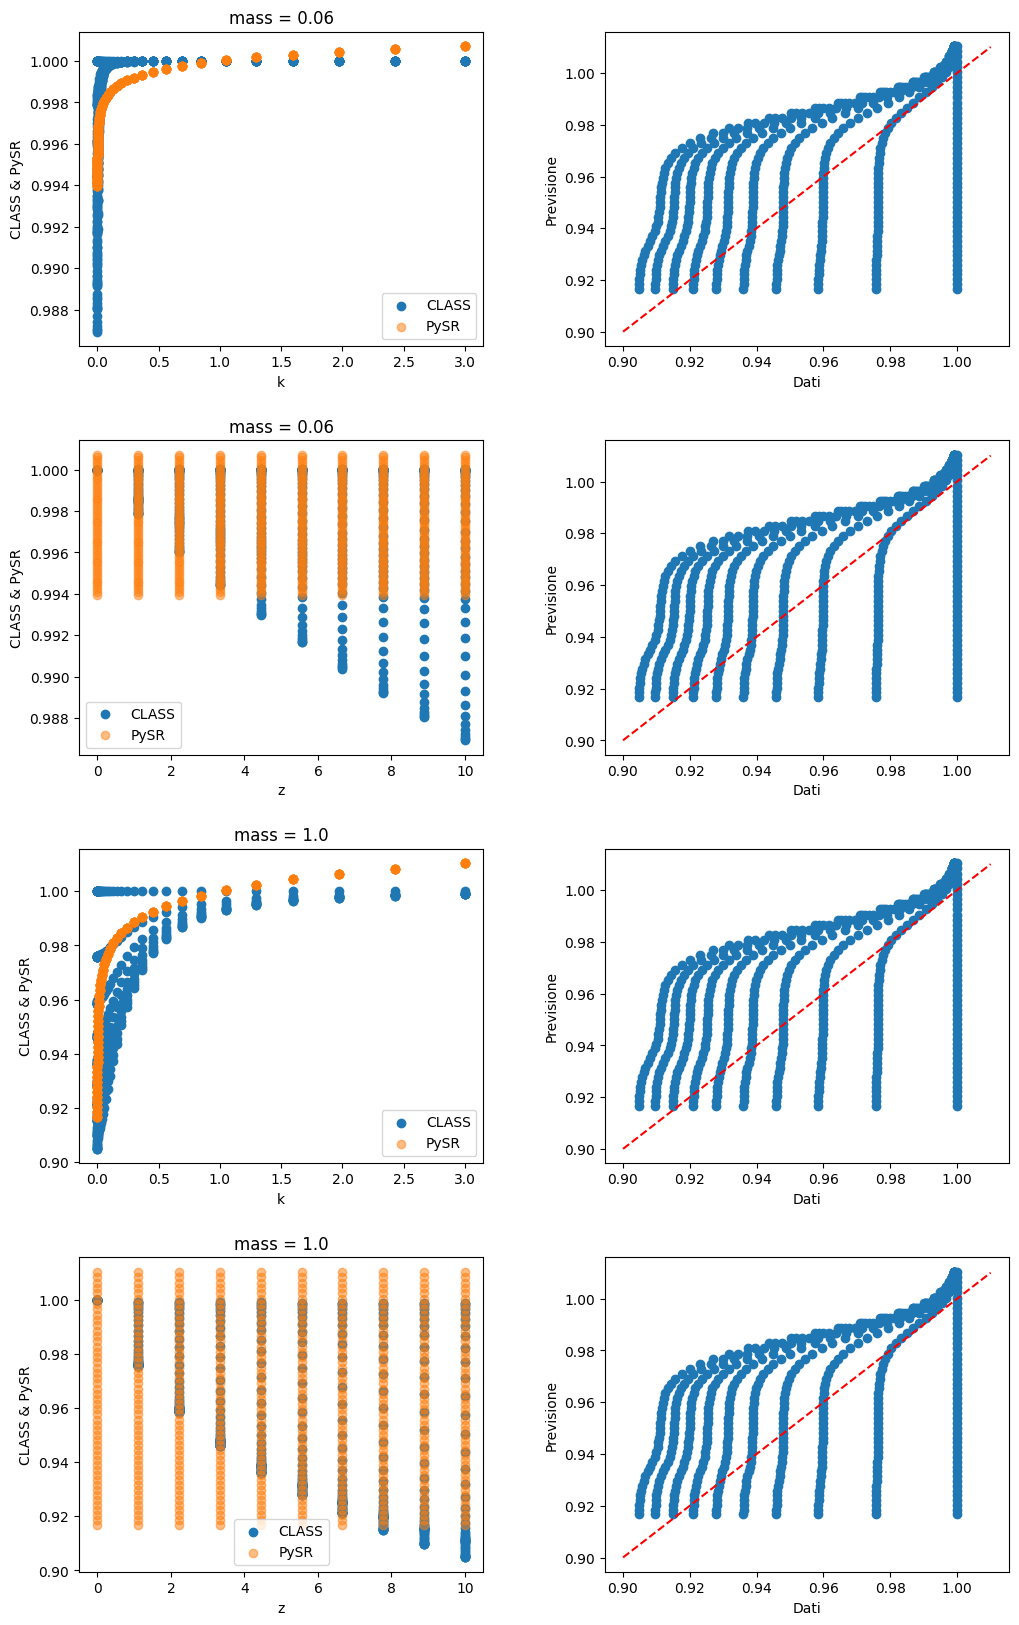

In [139]:
# plotto le predizioni di PySR contro i dati di CLASS

fig, axs = plt.subplots(4, 2, figsize=(12, 20), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

j = 0
for m in range(nm) :
    # x: scala
    axs[j,0].scatter(x[m][:,1], x[m][:,3], label='CLASS')
    axs[j,0].scatter(x[m][:,1], pred2[m][:], alpha=0.5, label='PySR')
    axs[j,0].set_xlabel('k')
    axs[j,0].set_ylabel('CLASS & PySR')
    axs[j,0].set_title('mass = ' + str(mm[m]))
    axs[j,0].legend()

    j = j+1

    # x: redshift
    axs[j,0].scatter(x[m][:,2], x[m][:,3], label='CLASS')
    axs[j,0].scatter(x[m][:,2], pred2[m][:], alpha=0.5, label='PySR')
    axs[j,0].set_xlabel('z')
    axs[j,0].set_ylabel('CLASS & PySR')
    axs[j,0].set_title('mass = ' + str(mm[m]))
    axs[j,0].legend()

    j = j+1

for i in range(4) :
    axs[i,1].plot(x[m][:,3], pred2[m][:], 'o')
    xlim = axs[i,1].get_xlim()
    t = np.arange(xlim[0], xlim[1]+0.01, 0.01)
    axs[i,1].plot(t, t, linestyle='--', color='red')
    axs[i,1].set_xlabel('Dati')
    axs[i,1].set_ylabel('Previsione')

plt.savefig('prova2.pdf')
plt.show()